## Problem 7

### Environment Setup

In [343]:
# env setup
import os
import time
import pandas as pd
import numpy as np
import math
from decimal import Decimal
from scipy.special import factorial
import matplotlib.pyplot as plt
from scipy.stats import gamma
from plotnine import *

#EDIT with your working DIR
DATA_DIR = "/home/jack/Documents/Advanced-ML-Course/Assignment_2/data"

In [2]:
# read in the data
gibbs_data = pd.read_csv(os.path.join(DATA_DIR, "gibbs.csv"))
X = gibbs_data.value

### Gibbs Sampler Implementation

We know that the conditional posterior distribution will be $\lambda | X \sim Gamma(30 +\sum _{i=1}^{n}x_{i},\ 4 +n\!)$

This is also equavalent t0 $\lambda | X \sim Gamma(k+\sum _{i=1}^{n}x_{i},\ {\frac {\frac{1}{4}}{\frac{n}{4} +1}}\!)$

*This transformation is needed to apply numpy's function*

In [204]:
#sample statisitics needed
x_sum = X.sum().astype(np.int64)
n = X.shape[0]
logx_factorial_sum = np.log(factorial(X)).sum().astype(np.int64) # needed for plots later on

In [62]:
# Sampler Parameters/Setup
T = 1000 #burnin
beta_0 = ((1/4)) / ((n / 4) + 1)

In [228]:
# Gibbs Sampler Algorithm
lambdas = np.zeros(10000)
for i in range(0,10000):
    lambdas[i] = np.random.gamma(shape=30 + x_sum, scale= beta_0)
    
# remove burn-in (*not needed in this case, but implementing for completness)
lambdas_new = pd.DataFrame({"lam": lambdas[T:]})

### Plots and Diagnostics

**MAP and Simulated Values for Lambda**

The simulated and actual values are very close.

In [229]:
theoretical_map = (30 + x_sum) / (n + 4)
simulated_map = lambdas_new.lam.describe().xs('mean')
print(f"actual lambda MAP: {theoretical_map}")
print(f"simulated lambda MAP: {simulated_map}")

actual lambda MAP: 7.3173076923076925
simulated lambda MAP: 7.318936910199035


**Likelihood Function**

In [230]:
lambd_min = lambdas_new.lam.describe().xs('min')
lambd_max = lambdas_new.lam.describe().xs('max')

In [231]:
# likelihood functions
likelihood = lambda lambd: float( ( (Decimal(float(lambd))**Decimal(float(x_sum)) ) / Decimal(float(x_factorial_sum))) * Decimal(float(np.exp(-1*lambd*n))) )
log_likelihood = lambda lambd: -1*lambd*n - logx_factorial_sum + np.log(lambd)*x_sum

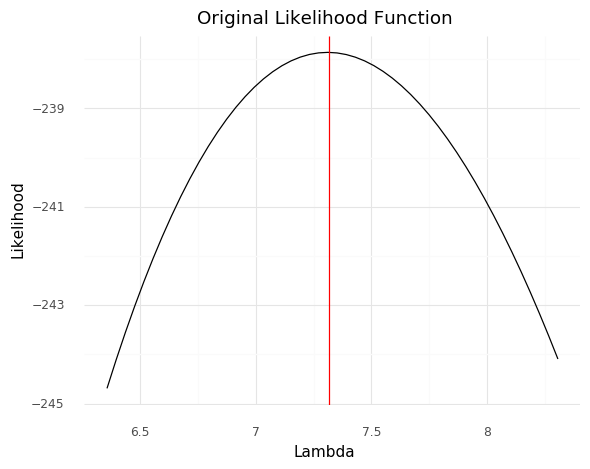

<ggplot: (-9223363258230219113)>

In [275]:
# create data for plotting
lamndas_lines = np.linspace(lambd_min, lambd_max).reshape(50,)
df_plot = pd.DataFrame({"lambdas": lamndas_lines,
                         "likelihood": [log_likelihood(lam) for lam in lamndas_lines] })

# Plot likelihood of Lambda from our original data generating function.
(ggplot(df_plot) + geom_line(aes(y='likelihood', x='lambdas')) + 
 theme_minimal() + geom_vline(xintercept = theoretical_map, color = "red") + # red line is theoretical MAP value
 labs(x = "Lambda", y = "Likelihood", title="Original Likelihood Function")) 

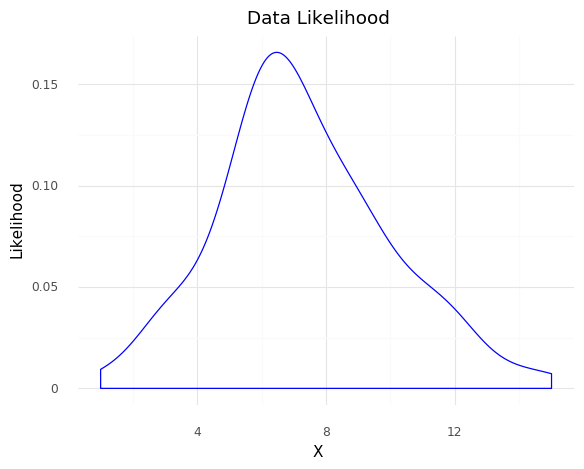

<ggplot: (-9223363258230343164)>

In [355]:
# Here is the true Bayesian likelihood of the data
(ggplot(gibbs_data) + geom_density(aes(x='value'), color="blue") + 
 theme_minimal() + labs(x = "X", y = "Likelihood", title="Data Likelihood")) 

**Posterior**

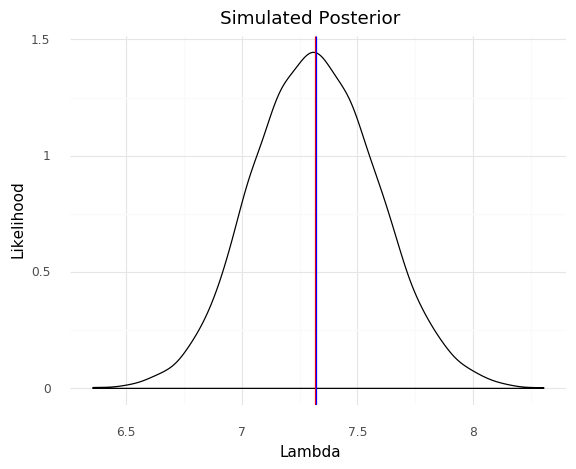

<ggplot: (8778624434808)>

In [351]:
# plot the simulated posterior distribution of lambda
(ggplot(lambdas_new) + geom_density(aes(x='lam')) + 
 theme_minimal() + geom_vline(xintercept = theoretical_map, color = "red") + # theoretical MAP
 geom_vline(xintercept = simulated_map, color = "blue") +
 labs(x = "Lambda", y = "Likelihood", title="Simulated Posterior")) 

**Posterior Predictive**

In [292]:
# Sample from posterior distribution of lambda 
lamds_post_samp = lambdas_new.lam.sample(5000).to_numpy().reshape((5000,1))

# Use MAP estimates to generate fake new data examples **ususally/in practice this would be real data values we're interested in predicting
X_new = np.random.poisson(lam=simulated_map, size=2).reshape((1,2)) # using new two "new" data points

In [297]:
# create a simulated sample of data from all possible values in the posterior predictive distribution
post_sample = pd.DataFrame(np.random.poisson(lam=lamds_post_samp, size=(5000,1)))
post_sample.columns = ['new_sample']

observation 1: 6, probability = 0.1308
observation 2: 9, probability = 0.12


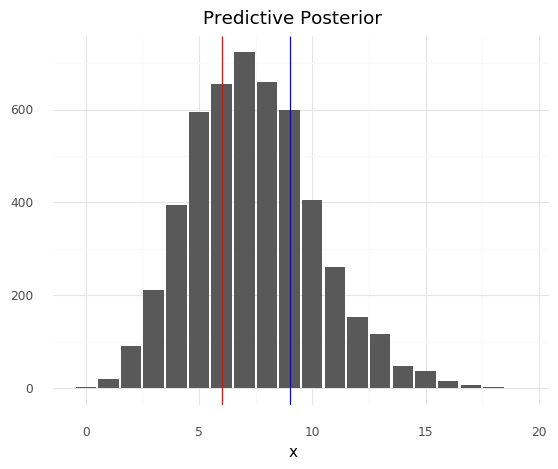

<ggplot: (-9223363258230313710)>

In [341]:
# determine probabilities of two example data points
x1_prob = sum(post_sample.new_sample == X_new[0][0]) / post_sample.new_sample.to_numpy().shape[0]
x2_prob = sum(post_sample.new_sample == X_new[0][1]) / post_sample.new_sample.to_numpy().shape[0]

# Plot predictive posterior distribution
print(f"observation 1: {X_new[0][0]}, probability = {x1_prob}")
print(f"observation 2: {X_new[0][1]}, probability = {x2_prob}")

(ggplot(post_sample, aes(x = 'new_sample')) +
        geom_bar() + 
        geom_vline(xintercept=X_new[0][0], color = "red") +
        geom_vline(xintercept=X_new[0][1], color = "blue") +
        theme_minimal() + labs(x = "x", y = "", title="Predictive Posterior"))

**Diagnostics**

In [269]:
lambdas_new = lambdas_new.reset_index()

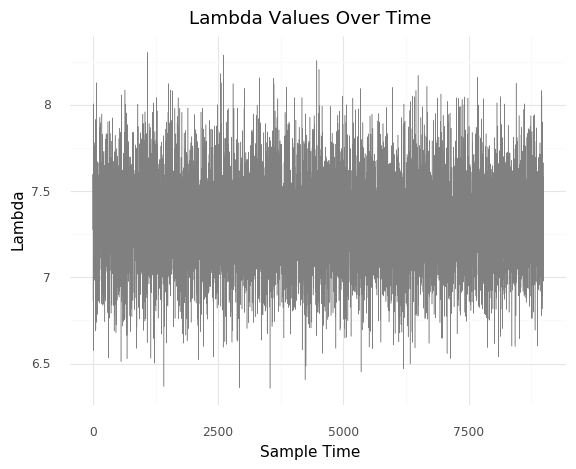

<ggplot: (8778624619647)>

In [274]:
(ggplot(lambdas_new, aes(x = 'index',y = 'lam')) +
        geom_line(size = 0.2, color="grey") + theme_minimal() +
        labs(x = "Sample Time", y = "Lambda", title="Lambda Values Over Time") )